# <center>COVID-19 Report Cases and Google Trend Data Exploratory Data Analysis</center>

In this notebook, we briefly analyzed the covid-19 case reports and Google Search Trend data.

The covid-19 data were from the given data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data. The time series and daily reports in this folder were automatically updated. We pulled the most recent data on Apr 12 from Github and performed the following analysis.

Section 1. We analyzed covid-19 trends in US states as well as all other countries. By Apr 12, 2020, New York was the most-serverely influenced state by having more than 175,000 reported cases and more than 9,000 reported deaths. Global-wise, US has the most reported cases and the most reported deaths. An interactive world map of coronavirus cases is shown in the end of this section.

Section 2. The Google trend data are imported using $pytrends$ pseudo API for Google Trends. The word $coronavirus$ was used as the keyword, and relative search interest in each country was plotted. We also demonstrated how Google Search Trend changed daily in US and Italy, in both of which the search interest grew until mid-March, 2020 and then dropped. Related topics and queries to the term $coronavirus$ were also shown. A world map of google search interest on coronatvirus is displayed in the end of this section.

Section 3. We compared the accumulative coronavirus cases, daily changes of coronavirus cases and, the daily google search trend of coronvarius in US. We put these data together and observed that there have been a decrease interest in the google search trend already but the reported cases and daily case increment are still growing. The question we would like to ask is whether or to what degree would Google search trend reflect or predict the trend of coronavirus cases or daily changes. In order to get some idea on the correlation between google search trend and coronavirus cases, we would look at Korean and Chinese data, i.e. find the search trend of $코로나 바이러스$ (coronavirus in Korean) on Google and compare to the cases in Korea or find the search trend of $新冠病毒$ (coronavirus in Chinese) on Baidu and compare the case development in China. 

The datasets are quite clean so we don't need to worry too much about preprocessing. However, we need to find the most relevant parameters of coronavirus data that correlate with Google search data. Based on EDA, it looks like the accumulative cases count and daily increment either do not follow the trend of search data or have a huge lag in time. Could it be the daily death count? We will also incorporate internet search or mentioning of coronavirus from other database such as facebook or twitter. Before next milestone, we will build estimation models based on the search trend data and coronavirus cases deveopment in Korea or China to explore their correlation and the delays. In addition to web searches, we are also curious about how governments' response affect the pandemic development. For instance, how does a country's reported cases and reported deaths affected by the number of ICU beds, issue of lockdown order, GDP per capita, and etc. For the next milestone, we will explore the possibility of building predictive models with data from other countries and predict on the data from US. Furthermore, for the next milestone, we will compare a list of algorithms including the SIR epidemic model, different recurrent neural networks, and echo state reservoir computing. 

In [10]:
# ! pip install pytrends==1.1.3
# ! pip install geopandas

import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
# from pytrends.request import TrendReq
import seaborn as sns
from datetime import datetime
import geopandas as gpd #pip install geopandas
sns.set()

# pytrend = TrendReq()

%matplotlib inline

# 1. COVID-19 Reported Cases Data

## 1.1 US data

Here we briefly take a look at the time series of confirmed and death cases in the US. The original dataset provided county-specific data with detailed geolocation.

For EDA and future analysis potentially, we will group them by state and only analyze the data at state level or above.

In [11]:
# pull the data from github, updated daily
url_confirmed="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
confirmed_df=pd.read_csv(io.StringIO(requests.get(url_confirmed).content.decode('utf-8')))

url_death="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
death_df=pd.read_csv(io.StringIO(requests.get(url_death).content.decode('utf-8')))

confirmed_df.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,84,93,112,113,121,121,128,130,133,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,316,452,475,513,573,620,683,725,788,897
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,37,40,42,43,43,45,45,50,51,51


Matplotlib is building the font cache using fc-list. This may take a moment.


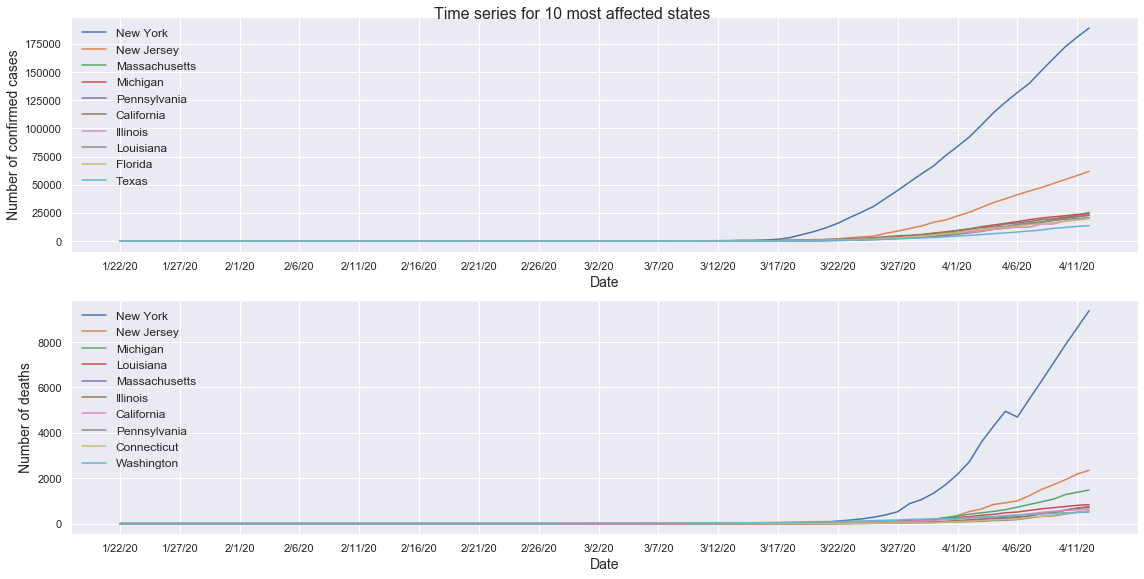

In [12]:
# Groupby state
confirmed_df_state = confirmed_df.groupby('Province_State')[confirmed_df.columns.values[11:]].sum()
death_df_state = death_df.groupby('Province_State')[death_df.columns.values[11:]].sum().drop(columns= ['Population'])

# Sort by total cases to date
confirmed_df_state_sort = confirmed_df_state.sort_values(by = confirmed_df.columns.values[-1], ascending = False)
death_df_state_sort = death_df_state.sort_values(by = death_df.columns.values[-1], ascending = False)

# Plot the top ten
confirmed_top10 = confirmed_df_state_sort.iloc[0:10].T
death_top10 = death_df_state_sort.iloc[0:10].T

fig,ax = plt.subplots(2,1,figsize = [16,8])
fig.subplots_adjust(top = 0.8)

confirmed_top10.plot(legend=True, ax = ax[0], x_compat=True)
ax[0].legend(fontsize = 12, frameon = False)
ax[0].set_xlabel('Date', fontsize = 14)
ax[0].set_ylabel('Number of confirmed cases', fontsize = 14)
ax[0].set_xticks(np.arange(0,len(death_top10),5))
ax[0].set_xticklabels(death_top10.index.values[np.arange(0,len(death_top10),5)])

death_top10.plot(legend=True, ax = ax[1], x_compat=True)
ax[1].legend(fontsize = 12, frameon = False)
ax[1].set_xlabel('Date', fontsize = 14)
ax[1].set_ylabel('Number of deaths', fontsize = 14)
ax[1].set_xticks(np.arange(0,len(death_top10),5))
ax[1].set_xticklabels(death_top10.index.values[np.arange(0,len(death_top10),5)])

plt.suptitle('Time series for 10 most affected states', fontsize = 16, y = 1)
plt.tight_layout()
plt.show()

From the plot above, we can find that New York is the most affected state with the highest number of confirmed cases and deaths while New Jersey ranked the second.

## 1.2 Global data

Here we analyzed the global data in the same way as we did for the US data. Instead of grouping by states, here we grouped by country/region.

In [13]:
url_confirmed_global="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
global_confirmed_df=pd.read_csv(io.StringIO(requests.get(url_confirmed_global).content.decode('utf-8')))

url_death_global="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
global_death_df=pd.read_csv(io.StringIO(requests.get(url_death_global).content.decode('utf-8')))

global_confirmed_df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,281,299,349,367,423,444,484,521,555,607
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,304,333,361,377,383,400,409,416,433,446
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914


In [14]:
# Search by country_name
country_name = 'US'
global_confirmed_df.loc[global_confirmed_df['Country/Region'] == country_name]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,275586,308853,337072,366667,396223,429052,461437,496535,526396,555313


In [15]:
global_confirmed_df_sort = global_confirmed_df.sort_values(by = global_confirmed_df.columns.values[-1], ascending = False).drop(columns = ['Province/State', 'Lat', 'Long']).set_index('Country/Region')
global_death_df_sort = global_death_df.sort_values(by = global_death_df.columns.values[-1], ascending = False).drop(columns = ['Province/State', 'Lat', 'Long']).set_index('Country/Region')
global_confirmed_df_sort.head(5)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
US,1,1,2,2,5,5,5,5,5,7,...,275586,308853,337072,366667,396223,429052,461437,496535,526396,555313
Spain,0,0,0,0,0,0,0,0,0,0,...,119199,126168,131646,136675,141942,148220,153222,158273,163027,166831
Italy,0,0,0,0,0,0,0,0,0,2,...,119827,124632,128948,132547,135586,139422,143626,147577,152271,156363
France,0,0,2,3,3,3,4,5,5,5,...,64338,89953,92839,98010,109069,112950,117749,124869,129654,132591
Germany,0,0,0,0,0,1,4,4,4,5,...,91159,96092,100123,103374,107663,113296,118181,122171,124908,127854


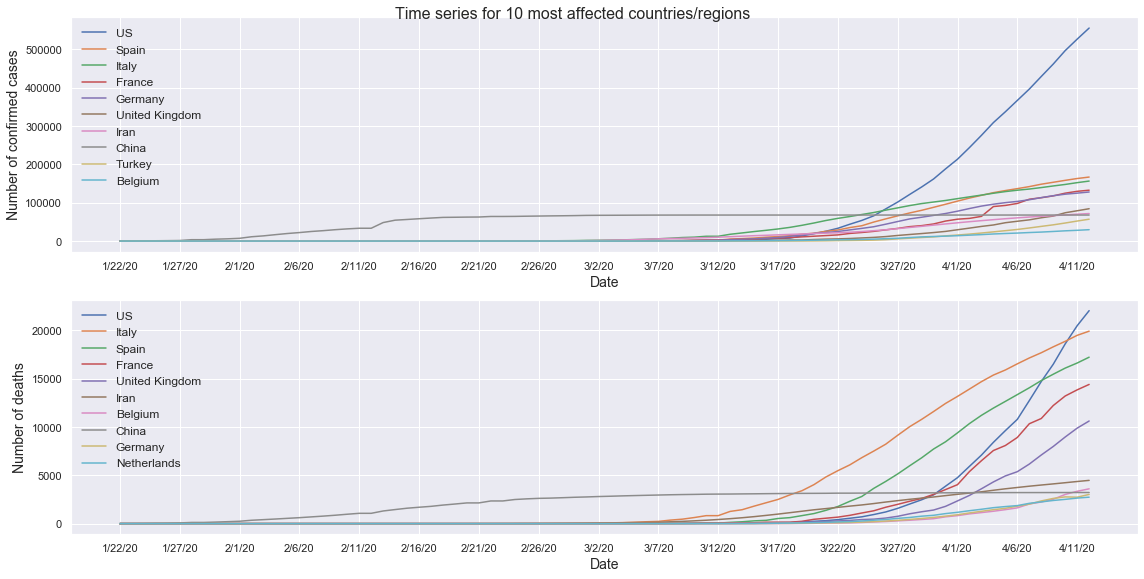

In [16]:
# Plot the top ten
global_confirmed_top10 = global_confirmed_df_sort.iloc[0:10].T
global_death_top10 = global_death_df_sort.iloc[0:10].T

fig,ax = plt.subplots(2,1,figsize = [16,8])
fig.subplots_adjust(top = 0.8)

global_confirmed_top10.plot(legend=True, ax = ax[0], x_compat=True)
ax[0].legend(fontsize = 12, frameon = False)
ax[0].set_xlabel('Date', fontsize = 14)
ax[0].set_ylabel('Number of confirmed cases', fontsize = 14)
ax[0].set_xticks(np.arange(0,len(global_confirmed_top10),5))
ax[0].set_xticklabels(global_confirmed_top10.index.values[np.arange(0,len(global_confirmed_top10),5)])

global_death_top10.plot(legend=True, ax = ax[1], x_compat=True)
ax[1].legend(fontsize = 12, frameon = False)
ax[1].set_xlabel('Date', fontsize = 14)
ax[1].set_ylabel('Number of deaths', fontsize = 14)
ax[1].set_xticks(np.arange(0,len(global_death_top10),5))
ax[1].set_xticklabels(global_death_top10.index.values[np.arange(0,len(global_death_top10),5)])

plt.suptitle('Time series for 10 most affected countries/regions', fontsize = 16, y = 1)
plt.tight_layout()
plt.show()

From the figure above, we spotted a few interesting points.

1. The spread of coronavirus took off in different parts of the world at different time. China started in late January while Iran and Italy started to observe large increase of confirmed cases in early March. US and other European countries started later in March. This indicated that location-specific data would be worth checking.

2. Most countries in the top 10 list still haven't reached the peak of this pandemic except for China. If the peak is still not observed by the end of this project, we might need to take extra caution when applying the model in future. 

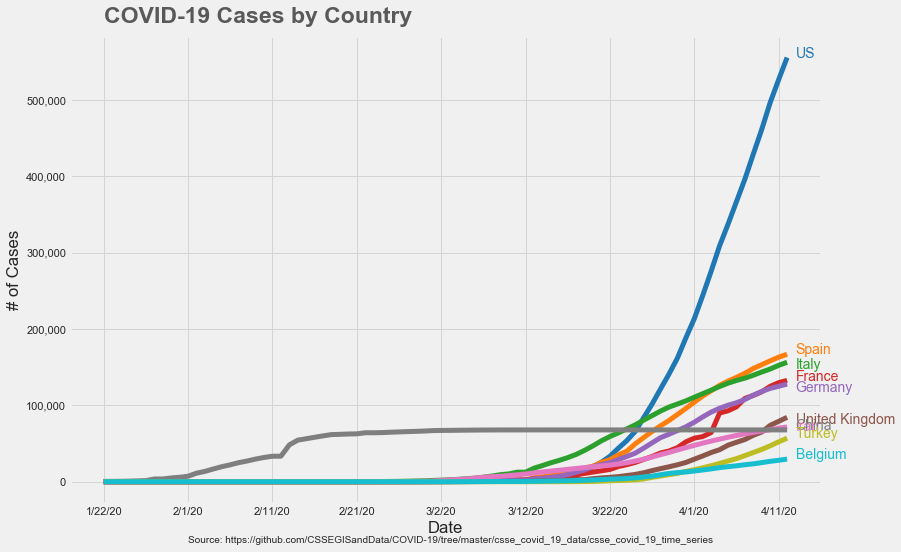

In [17]:
# Better visualization of ten most affected countries.
from pylab import *
cmap = cm.get_cmap('tab10', 10)    # PiYG
color_list = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_list.append(matplotlib.colors.rgb2hex(rgb))
    
plt.style.use('fivethirtyeight')
plot = global_confirmed_top10.plot(figsize=(12,8), color=color_list, linewidth=5, legend=False)
plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_xlabel('Date')
plot.set_ylabel('# of Cases')

i = 0
for country in list(global_confirmed_top10.columns.values):
    if country == 'Italy' or country == 'United Kingdom':
        plot.text(x = len(global_confirmed_top10.index), y = global_confirmed_top10[country].max()-8000, c = color_list[i], s = country)
        
    elif country == 'Germany': 
        plot.text(x = len(global_confirmed_top10.index), y = global_confirmed_top10[country].max()-10000, c = color_list[i], s = country)
    
    elif country == 'Iran': 
        plot.text(x = len(global_confirmed_top10.index), y = global_confirmed_top10[country].max()-5000, c = color_list[i], s = country)
    
    else:
        plot.text(x = len(global_confirmed_top10.index), y = global_confirmed_top10[country].max(), c = color_list[i], s = country)
    i+=1

plot.text(x = 0, y = int(global_confirmed_top10.max().max())+45000, s = "COVID-19 Cases by Country", fontsize = 23, weight = 'bold', alpha = .75)
plot.text(x = 10, y = -80000,s = 'Source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series', fontsize = 10)
plt.show()

## 1.3 Global mapping on a certain day

This is an interactive map for confirmed and death cases globally. The number as shown is the total number summed from certain country/region. Finer spatial resolution can be achieved for a specific country, such as China and the US. 

In [20]:
from datetime import datetime

In [21]:
print(datetime.date(datetime.now()))

2020-04-13


In [24]:
# Specify the date
date = '04-12-2020'

# pull data from Github
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+date+'.csv'
df=pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))

# Groupby country
df_country = df.groupby('Country_Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
df_country['Lat'] = df.groupby('Country_Region').agg({'Lat': np.nanmean})['Lat'].values
df_country['Long_'] = df.groupby('Country_Region').agg({'Long_': np.nanmean})['Long_'].values

/Users/yichujin/opt/anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [25]:
#!pip install plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

#mean = df['Confirmed'].mean()
df = df_country
mean = 5000
normlised_data_C = [value/mean + 10 for value in  df['Confirmed']]
normlised_data_D = [value/mean+3 if value != 0  else value for value  in df['Deaths']]
normlised_data_R = [value/mean + 3 if value != 0  else value for value  in df['Recovered']]

hoverdata1 = df['Country_Region'] + " - "+['Confirmed cases: ' + str(v) for v in df['Confirmed'].tolist()]
hoverdata2 = df['Country_Region'] + " - "+['Death: ' + str(v) for v in df['Deaths'].tolist()]
hoverdata3 = df['Country_Region'] + " - "+['Recovered: ' + str(v) for v in df['Recovered'].tolist()]
fig = make_subplots()
fig1 = go.Figure(data=go.Scattergeo(
        lon = df['Long_'],
        lat = df['Lat'],
    name = 'Confirmed cases',
        hovertext = hoverdata1,
        marker = dict(
            size =  normlised_data_C,
            opacity = 0.5,
            color = 'blue',
            line = dict(
                width=0,
                color='rgba(102, 102, 102)'
            ),
        ),
        ))

fig2 = go.Figure(data=go.Scattergeo(
        lon = df['Long_'],
        lat = df['Lat'],
    name = 'Deaths',
        hovertext = hoverdata2,
        marker = dict(
            size =  normlised_data_D,
            opacity = 0.5,
            color = 'red',
            line = dict(
                width=0,
                color='rgba(102, 102, 102)'
            ),
        ),
        ))


fig3= go.Figure(data=go.Scattergeo(
        lon = df['Long_'],
        lat = df['Lat'],
        hovertext = hoverdata3,
     name = 'Recovered',
        marker = dict(
            size =  normlised_data_R,
            opacity = 0.5,
            color = 'green',
            line = dict(
                width=0,
                color='rgba(102, 102, 102)'
            ),
        ),
        ))

fig.add_trace(fig1.data[0])
fig.add_trace(fig2.data[0])
#fig.add_trace(fig3.data[0])

fig.update_layout(
        title = 'The global impact of COVID-19',
    legend=dict(
        itemsizing = "constant",
        font=dict(
            family="sans-serif",
            size=20,
            color="black"
        )
    )
)
fig.show()

# 2 Google Trend Analysis

## 2.1 Interest by country

Each country's search of key word = 'coronavirus' on google is summarized here. Each country's value is normalized (with the maximum being 100 and the minimum being 0). By April 10, 2020, Italy has the highest relative interest.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

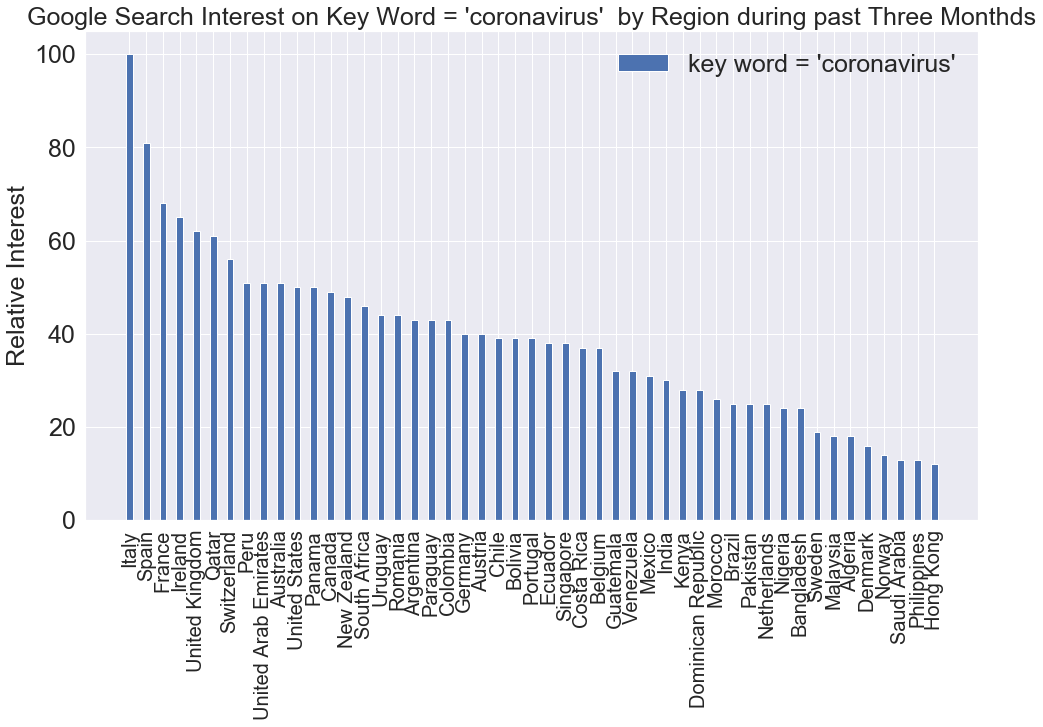

In [2]:
kw_list=['coronavirus']
pytrend.build_payload(kw_list=kw_list,timeframe = 'today 3-m')#import data from GOOGLE trend API

# Interest by Region

region_df = pytrend.interest_by_region()
region_df = region_df[region_df.coronavirus > 10]
region_df = region_df.reset_index()
region_df = region_df.sort_values('coronavirus',ascending=False)#sort the countries by relative interest
labels = region_df['geoName']

fig,ax = plt.subplots(1,1,figsize=(16,9))
x = np.arange(len(labels))#the label locations
width = 0.4
ax.bar(x,height=region_df.coronavirus,width=width,label = 'key word = \'coronavirus\'')
#ax.bar(x+0.5*width,height=region_df.COVID19,width=width,label='COVID19') #can add another key word into the plot
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=20)
ax.set_ylabel("Relative Interest",fontsize=25)
ax.set_yticklabels(labels = [0,20,40,60,80,100] ,fontsize=25)
ax.legend(frameon=False,fontsize=25)
ax.set_title("Google Search Interest on Key Word = 'coronavirus'  by Region during past Three Monthds",fontsize=25)
plt.xticks(rotation=90)

## 2.2 Interest over time in US and Italy in past Three Months

Here we demonstrate a time series of daily search of $coronavirus$ in US and Italy. In the US, there has been an increase interest since late-February until March 15th. Since March 15th, the search interest in $coronavirus$ has decreased, although there are several spikes in some particular days. In Italy, there has been some irregular spikes. We will analyze in detail why google trend behaves like this before the next Milestone.

In [24]:
#interest over time in US and Italy


def gen_region_time_df(region='',kw_list=['coronavirus'],timeframe='today 3-m',gprop = ''):
    pytrend.build_payload(kw_list=kw_list, timeframe='today 3-m', geo = region)
    # Input
    # kw_list: keyword list, default is ['coronavirus']
    # region: two-letter country code, e.g. 'US' for united states and 'IT' for Italy, default is world
    # timeframe = same keyword as 'timeframe' in 'build_payload'. default is 'today 3-m', which means past three months from today
    # gprop: what google property to filter to, e.g. 'images'; default is all.
    #
    #
    #
    #
    # Output
    # interest_over_time_df: dataframe of coronavirus search per 'day' in 'region'
    interest_over_time_df = pytrend.interest_over_time()
    interest_over_time_df = interest_over_time_df.reset_index()
    return interest_over_time_df




In [29]:
#create dataframe

us_day_df = gen_region_time_df('US')
italy_day_df = gen_region_time_df('IT')

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

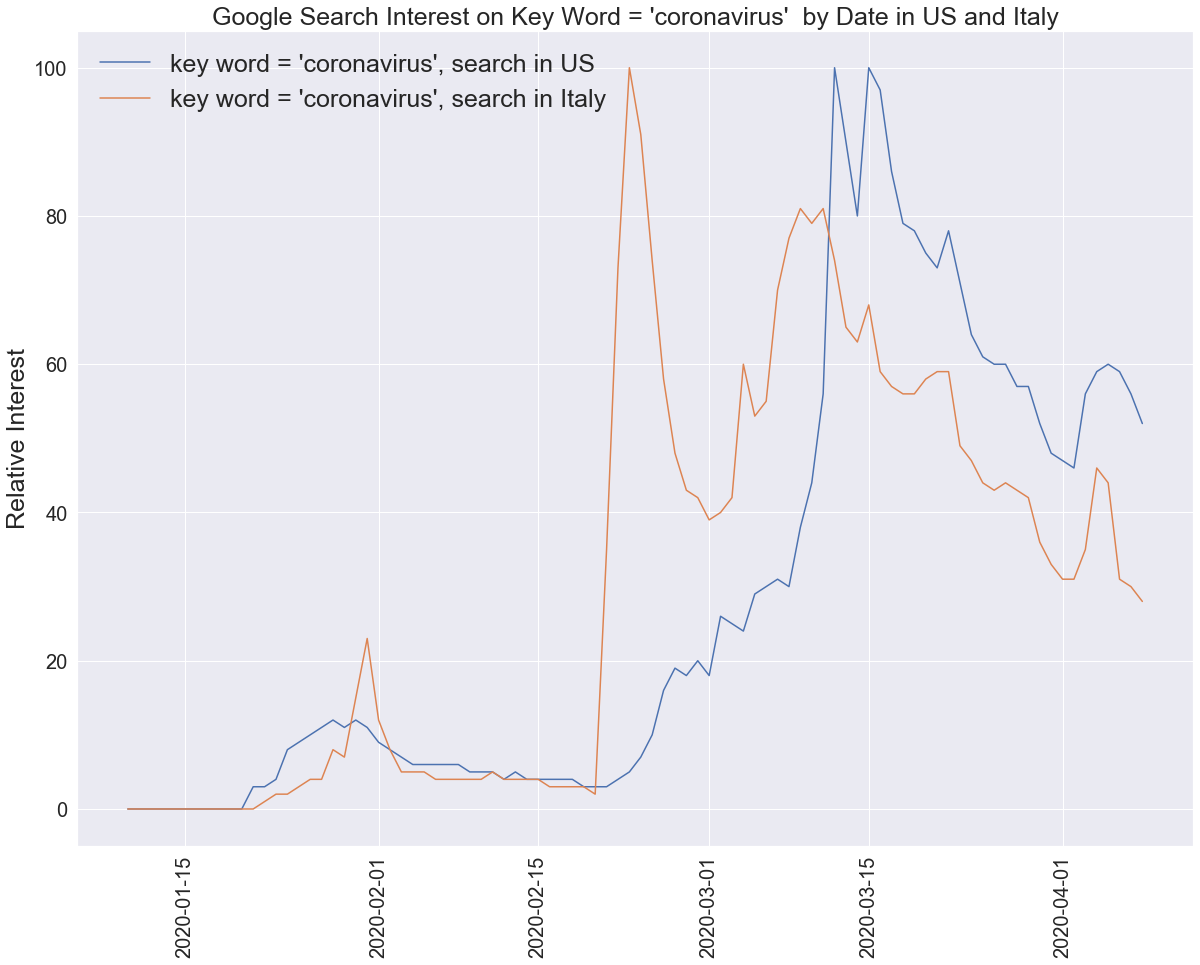

In [18]:
fig,ax = plt.subplots(1,1,figsize=(20,15))
ax.plot(us_day_df.date,us_day_df.coronavirus,label = 'key word = \'coronavirus\', search in US')
ax.plot(italy_day_df.date,italy_day_df.coronavirus,label = 'key word = \'coronavirus\', search in Italy')

ax.set_ylabel("Relative Interest",fontsize=25)
#ax.set_yticklabels(labels = [0,20,40,60,80,100] ,fontsize=25)
ax.legend(frameon=False,fontsize=25)
#ax.set_ylim(0,200)
ax.set_title("Google Search Interest on Key Word = 'coronavirus'  by Date in US and Italy",fontsize=25)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)

## 2.3 Related Topics and Queries

Here we looked at the top related topics and queries when people search the term $coronavirus$ in US. We found out that people like to search $coronavirus$ in $Italy$ and $China$. The search amount increased by relatively 190,000% in the past 3 months while search of $coronavirus\ in\ US$ has grown 1,950%. People also searched for $Coronavirus$ $Symptom$ and $death$. Many also like to rely on CDC, so they searched for $Centers\ for\ Disease\ Control\ and\ Prevention$. People believe the data from Johns Hopkins University, so they searched for $Johns\ Hopkins\ University$.

The most trending queries are $coronavirus\ update$, $coronavirus\ map$, $USA\ coronavirus$

In [28]:

pytrend.build_payload(kw_list=kw_list, timeframe='today 3-m', geo = 'US')

#related topics

us_topic_df = pytrend.related_topics()
us_topic_df['coronavirus']['rising']

,value,formattedValue,link,topic_mid,topic_title,topic_type
0,195350,Breakout,/trends/explore?q=/m/0d05w3&date=today+3-m&geo=US,/m/0d05w3,China,Country in East Asia
1,191050,Breakout,/trends/explore?q=/m/03rjj&date=today+3-m&geo=US,/m/03rjj,Italy,Country in Europe
2,154650,Breakout,/trends/explore?q=/g/11csq9vs7j&date=today+3-m...,/g/11csq9vs7j,Centers for Disease Control and Prevention,Topic
3,150700,Breakout,/trends/explore?q=/m/01zrs&date=today+3-m&geo=US,/m/01zrs,Centers for Disease Control and Prevention,Federal agency
4,129150,Breakout,/trends/explore?q=/m/09kvv&date=today+3-m&geo=US,/m/09kvv,Johns Hopkins University,"Private university in Baltimore, Maryland"
5,1950,"+1,950%",/trends/explore?q=/m/09c7w0&date=today+3-m&geo=US,/m/09c7w0,United States,Country in North America
6,700,+700%,/trends/explore?q=/m/01b_06&date=today+3-m&geo=US,/m/01b_06,Symptom,Topic
7,250,+250%,/trends/explore?q=/m/01cpyy&date=today+3-m&geo=US,/m/01cpyy,Coronavirus,Virus


In [29]:
#related queries

us_query_df = pytrend.related_queries()
#display(us_query_df['coronavirus']['top'])
display(us_query_df['coronavirus']['rising'])

,query,value
0,coronavirus update,690000
1,coronavirus map,414300
2,usa coronavirus,390500
3,coronavirus tips,390350
4,thank you coronavirus helpers,200600
5,china coronavirus,186300
6,italy,186100
7,coronavirus deaths,181200
8,italy coronavirus,180450
9,coronavirus italy,179900


## 2.4 World Map

Here we create an interactive map for each country's interest in coronavirus. Geopanda, bokeh and json are used.

In [4]:
shapefile = './ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.iloc[4]=gdf.iloc[4].replace('United States of America','United States')
gdf.head()


,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [8]:
#region_df imported previously
region_df = pytrend.interest_by_region()
region_df = region_df.reset_index()
region_df['country']=region_df['geoName']
region_df.tail(4)

,geoName,coronavirus,country
246,Yemen,0,Yemen
247,Zambia,0,Zambia
248,Zimbabwe,0,Zimbabwe
249,Åland Islands,0,Åland Islands


In [9]:
#merge map and region df

merged_df = gdf.merge(region_df,on='country')
merged_df=merged_df.drop(['geoName'],axis=1)
merged_df.head()


,country,country_code,geometry,coronavirus
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0
1,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0
2,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",49
3,United States,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",50
4,Kazakhstan,KAZ,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0


In [10]:
import json
#Read data to json.
merged_json = json.loads(merged_df.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [12]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#An interactive map
#more info on https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column
#Define function that returns json_data for year selected by user.
    

geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][6]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 100, nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
tick_labels = {'0': '0', '5': '5', '10':'10', '15':'15', '20':'20', '25':'25', '30':'30','35':'35', '40': '40','50': '50','60': '60','70': '70','80': '>80'}
#Add hover tool
hover = HoverTool(tooltips = [ ('Country/region','@country'),('% coronavirus', '@coronavirus')])
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Coronavirus search on Google', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'coronavirus', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
p.add_layout(color_bar, 'below')
# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = 'coronavirus'
    
# Make a slider object: slider 
#slider = Slider(title = 'Year',start = 1975, end = 2016, step = 1, value = 2016)
#slider.on_change('value', update_plot)
# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p)
curdoc().add_root(layout)
#Display plot inline in Jupyter notebook
output_notebook()
#Display plot
show(layout)

Loading BokehJS ...

# 3 Compare COVID-19 Reported Cases, Daily Case Increment  and Google Search Trends of Coronavirus in US

We put these data together and observed that there have been a decrease interest in the google search trend already but the reported cases and daily case increment are still growing. The question we would like to ask is whether or to what degree would Google search trend reflect or predict the trend of coronavirus cases or daily changes. In order to get some idea on the correlation between google search trend and coronavirus cases, we would look at Korean and Chinese data, i.e. find the search trend of $코로나 바이러스$ (coronavirus in Korean) on Google and compare to the cases in Korea or find the search trend of $新冠病毒$ (coronavirus in Chinese) on Baidu and compare the case development in China. 

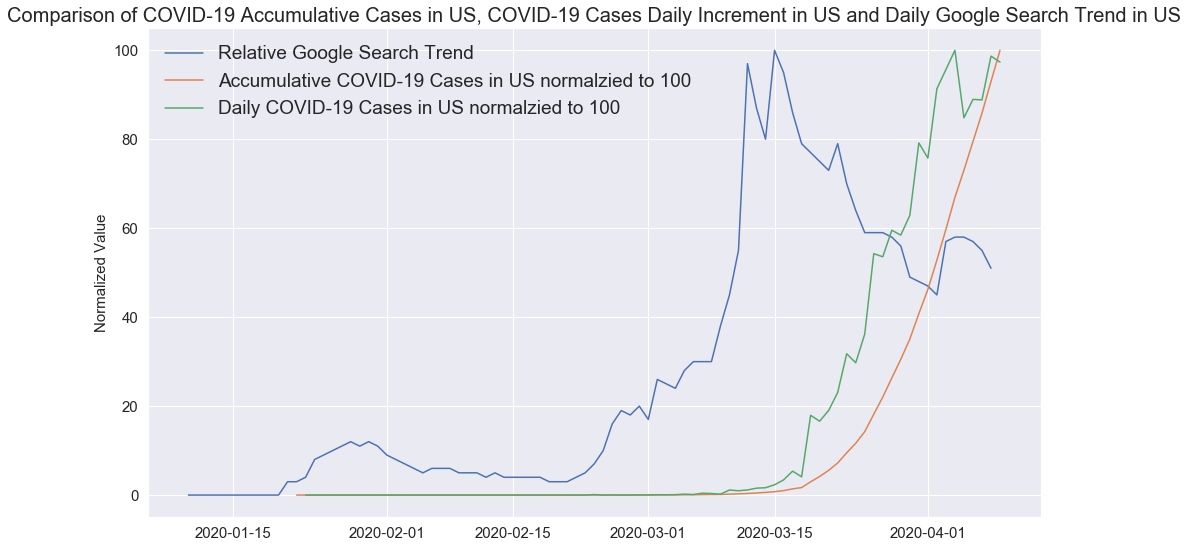

In [90]:
us_case_day = global_confirmed_top10['US']
us_case_day = us_case_day.reset_index()
us_case_day['date'] = us_case_day['index']
us_case_day['date']=pd.to_datetime(us_case_day['date'])

#construct increment dataframe, accounting for daily increment of cases in US
us_increment = us_case_day
us_increment['increment'] = us_increment['US'].diff()
us_increment = us_increment.dropna()
plt.figure(figsize=(16,9))
plt.plot(us_day_df['date'],us_day_df['coronavirus'],label='Relative Google Search Trend')
plt.plot(us_case_day['date'],us_case_day['US']/max(us_case_day['US'])*100,label = 'Accumulative COVID-19 Cases in US normalzied to 100')
plt.plot(us_increment['date'],us_increment['increment']/max(us_increment['increment'])*100,label = 'Daily COVID-19 Cases in US normalzied to 100')
plt.ylabel("Normalized Value",fontsize=15)
plt.legend(fontsize=19,frameon=False)
plt.title("Comparison of COVID-19 Accumulative Cases in US, COVID-19 Cases Daily Increment in US and Daily Google Search Trend in US",fontsize=20)
plt.tick_params(axis = 'both',labelsize = 15)
plt.show()
